
# Analisis de reservas de Uber y cancelaciones

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("ncr_ride_bookings.csv")

Establecer formato de fecha y hora, agregamos una columna con la hora de la reservación como un entero y una columna con el día de la semana

In [3]:
df["Date"] = pd.to_datetime(df["Date"])
df["Hour"] = df["Time"].str[:2].astype(int)
df["DayOfWeek"] = df["Date"].dt.day_name()

## Porcentaje de cancelaciones por día y hora

Agrupamos

In [4]:
grouped = df.groupby(["DayOfWeek", "Hour"]).agg(
    total_rides=("Booking ID", "count"),
    driver_cancels=("Cancelled Rides by Driver", "sum"),
    customer_cancels=("Cancelled Rides by Customer", "sum")
).reset_index()

Generamos los pivot para conductores y clientes según el porcentaje de cancelación

In [6]:
# Calcular porcentajes
grouped["Cancel % Driver"] = 100 * grouped["driver_cancels"] / grouped["total_rides"]
grouped["Cancel % Customer"] = 100 * grouped["customer_cancels"] / grouped["total_rides"]

# Pivot para heatmap (driver)
pivot_driver = grouped.pivot(index="DayOfWeek", columns="Hour", values="Cancel % Driver")

# Pivot para heatmap (customer)
pivot_customer = grouped.pivot(index="DayOfWeek", columns="Hour", values="Cancel % Customer")


#Ordenamos los días
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot_driver = pivot_driver.reindex(days_order)
pivot_customer = pivot_customer.reindex(days_order)

### Heatmaps

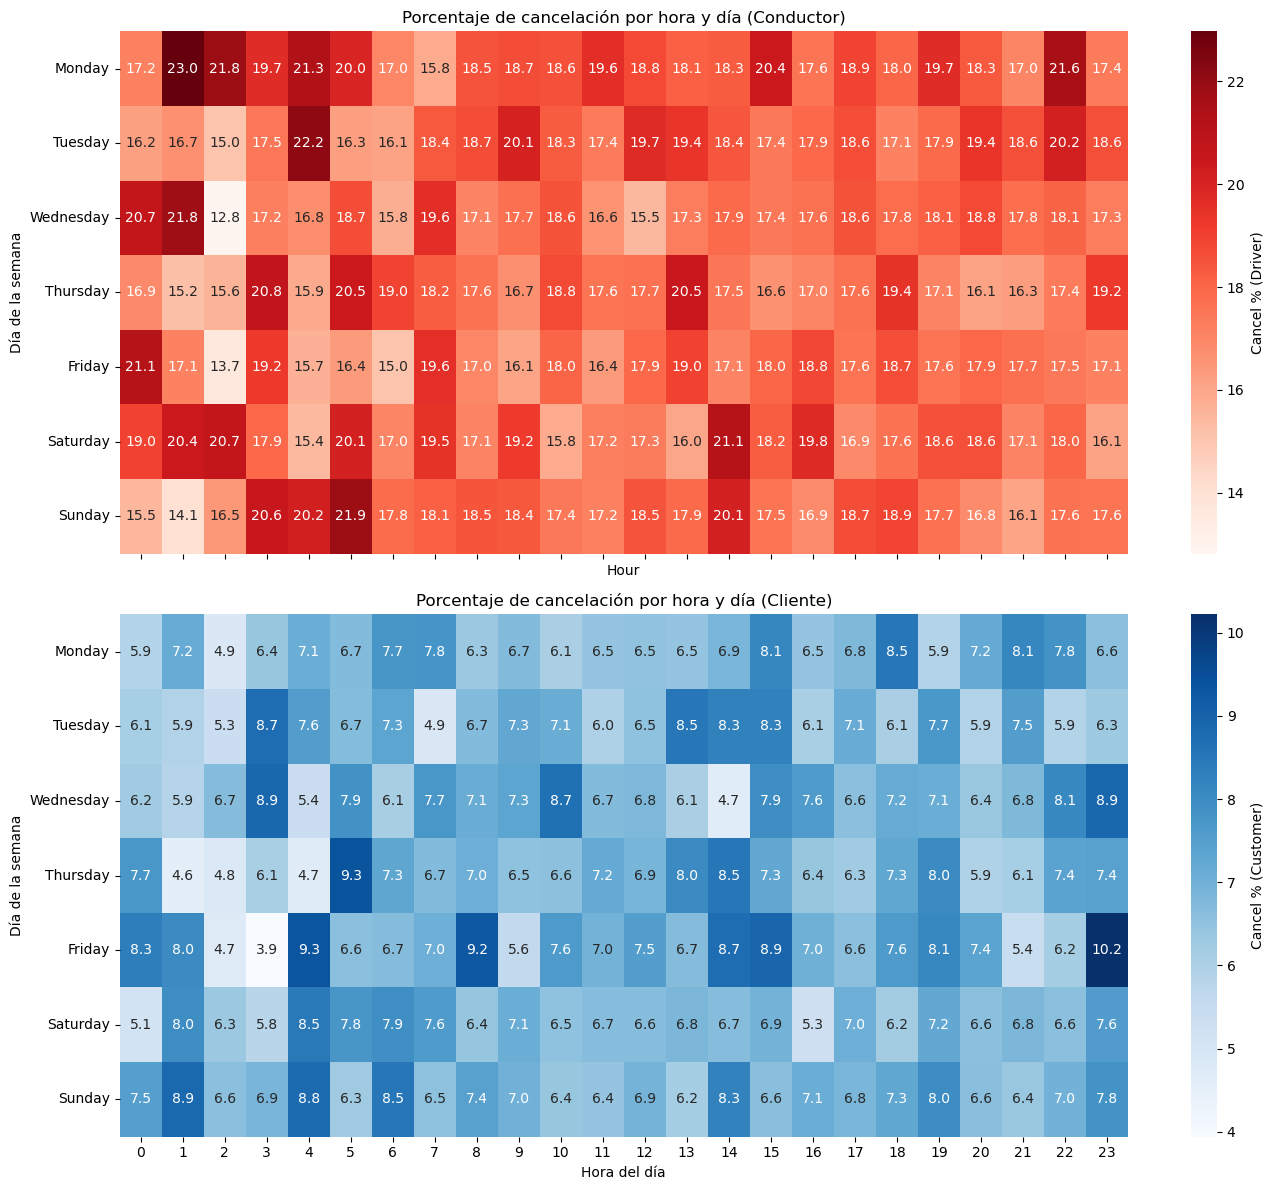

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

sns.heatmap(pivot_driver, annot=True, fmt=".1f", cmap="Reds",
            cbar_kws={'label': 'Cancel % (Driver)'}, ax=axes[0])
axes[0].set_title("Porcentaje de cancelación por hora y día (Conductor)")
axes[0].set_ylabel("Día de la semana")

sns.heatmap(pivot_customer, annot=True, fmt=".1f", cmap="Blues",
            cbar_kws={'label': 'Cancel % (Customer)'}, ax=axes[1])
axes[1].set_title("Porcentaje de cancelación por hora y día (Cliente)")
axes[1].set_ylabel("Día de la semana")
axes[1].set_xlabel("Hora del día")

plt.tight_layout()
plt.show()

## Razones de cancelación


In [8]:
#Filtro de Cancelaciones

cancel_filter = (
    (df["Cancelled Rides by Customer"].fillna(0) > 0) |
    (df["Cancelled Rides by Driver"].fillna(0) > 0) |
    (df["Booking Status"] == "No Driver Found")
)
df_cancelled = df[cancel_filter].copy()

# Nos quedamos con las cancelaciones que tienen razón de cliente
df_customer_reasons = df_cancelled[df_cancelled["Reason for cancelling by Customer"].notna()]

# Agrupamos por día, hora y razón
grouped_reasons = df_customer_reasons.groupby(
    ["DayOfWeek", "Hour", "Reason for cancelling by Customer"]
).size().reset_index(name="Count")

# Calcular porcentaje dentro de cada (día, hora)
grouped_reasons["TotalInSlot"] = grouped_reasons.groupby(["DayOfWeek", "Hour"])["Count"].transform("sum")
grouped_reasons["Percent"] = 100 * grouped_reasons["Count"] / grouped_reasons["TotalInSlot"]

# Ver las primeras filas
grouped_reasons.head()

,DayOfWeek,Hour,Reason for cancelling by Customer,Count,TotalInSlot,Percent
0,Friday,0,AC is not working,3,15,20.000000
1,Friday,0,Driver asked to cancel,4,15,26.666667
2,Friday,0,Driver is not moving towards pickup location,4,15,26.666667
3,Friday,0,Wrong Address,4,15,26.666667
4,Friday,1,AC is not working,1,15,6.666667


Visualizamos los datos en una grafica de barras apiladas

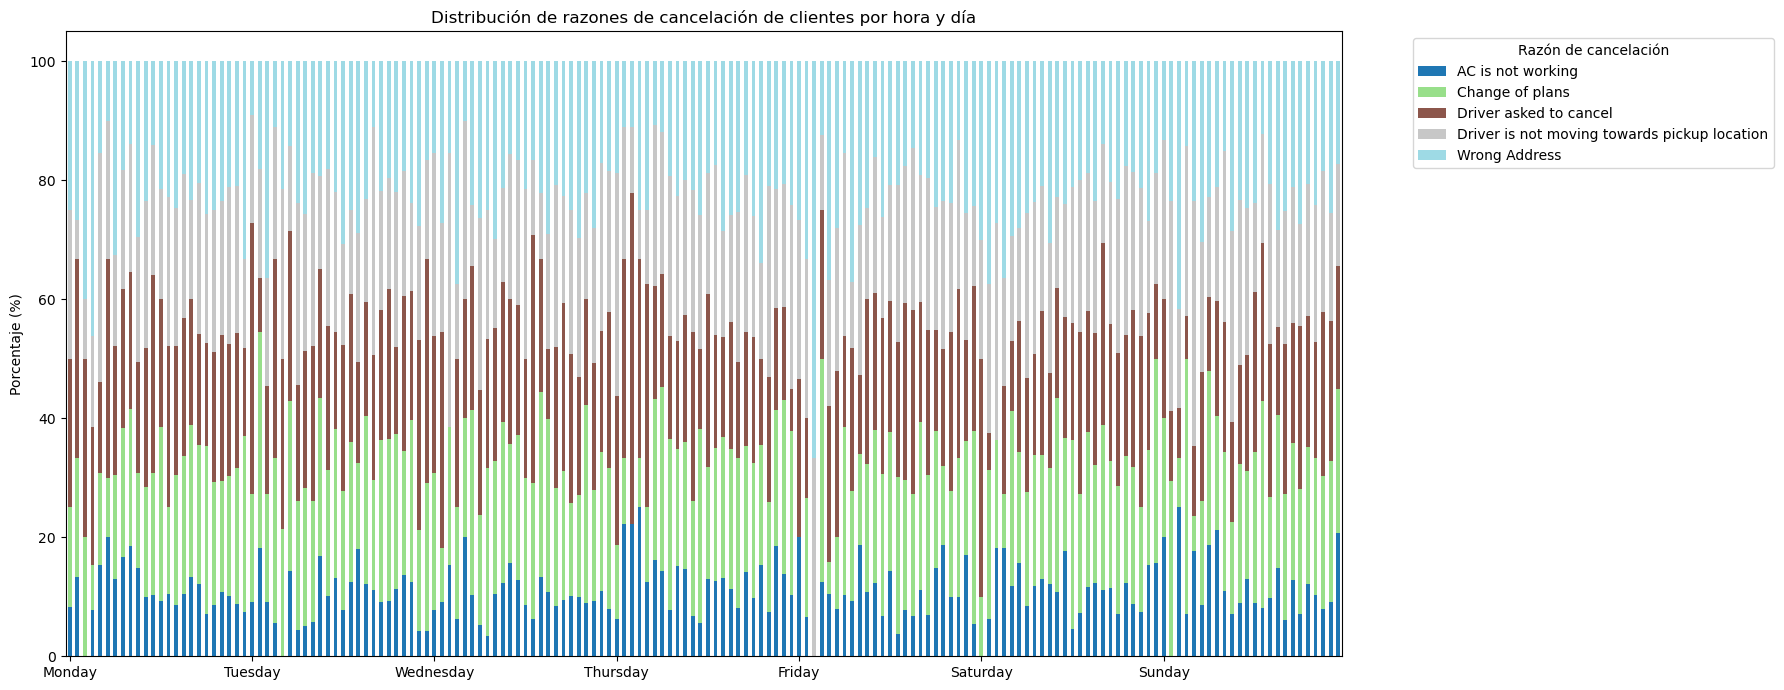

In [9]:
# Pivot para tener razones como columnas
pivot_reasons = grouped_reasons.pivot_table(
    index=["DayOfWeek", "Hour"],
    columns="Reason for cancelling by Customer",
    values="Percent",
    fill_value=0
)

# Ordenar días de la semana
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot_reasons = pivot_reasons.reindex(pd.MultiIndex.from_product(
    [days_order, range(24)], names=["DayOfWeek", "Hour"]
))

# Hacemos gráfico de barras apiladas
ax = pivot_reasons.plot(
    kind="bar", stacked=True, figsize=(18,7), colormap="tab20"
)

plt.title("Distribución de razones de cancelación de clientes por hora y día")
plt.ylabel("Porcentaje (%)")
plt.xlabel("")

# Etiquetas en el eje X solo cada 24 horas (cambio de día)
num_hours = 24
ticks = [i*num_hours for i in range(len(days_order))]
labels = days_order

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=0)

plt.legend(title="Razón de cancelación", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Vemos estos datos esto en relación al porcentaje total de cancelaciones

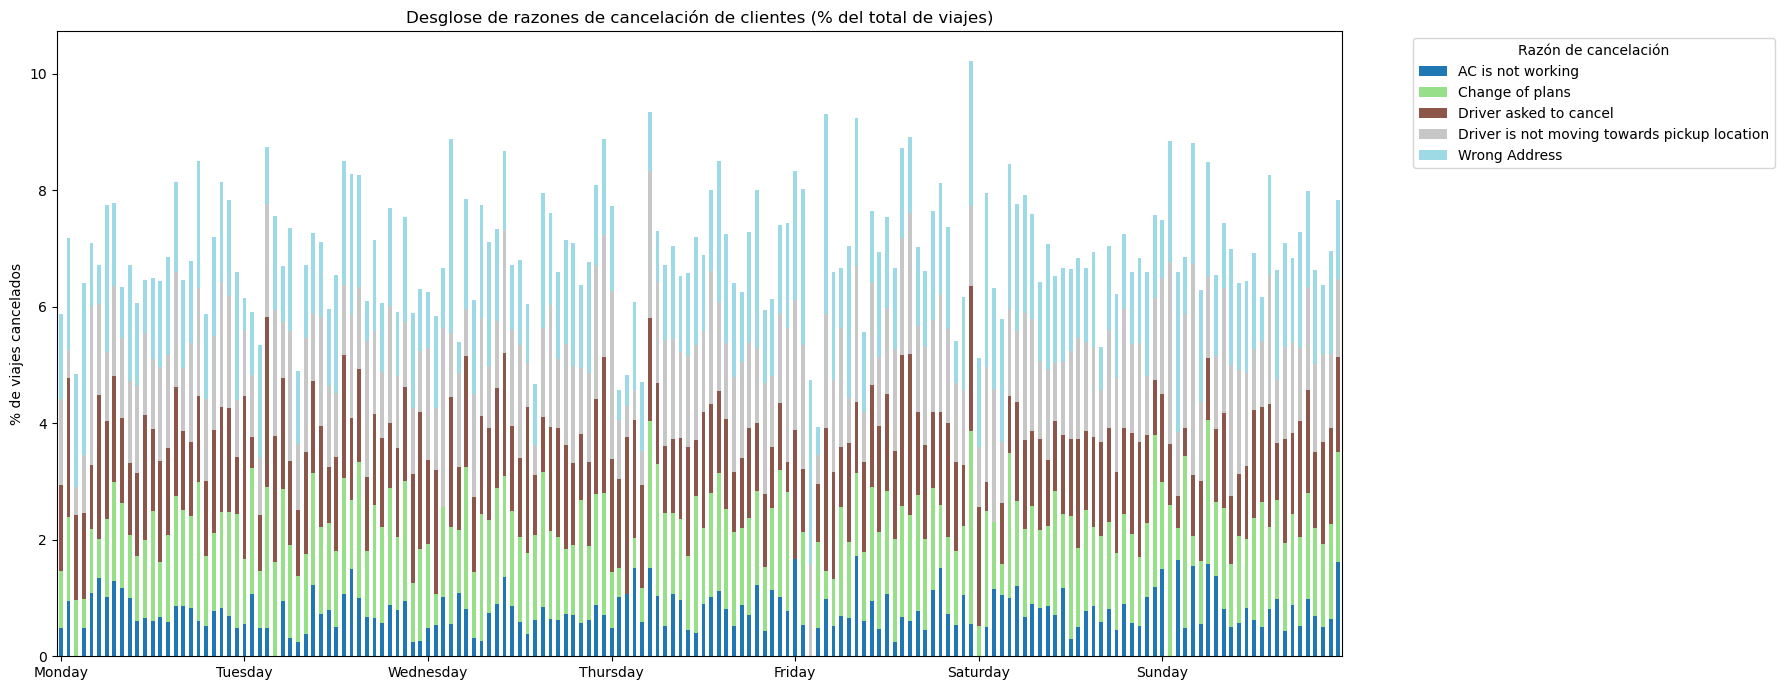

In [11]:
# 1. Filtrar solo cancelaciones explícitas (ya definido como cancel_filter antes)
df_cancelled = df[cancel_filter].copy()

# 2. Razones de cancelación de cliente
df_customer_reasons = df_cancelled[df_cancelled["Reason for cancelling by Customer"].notna()]

# 3. Agrupar por día, hora y razón
reasons_breakdown = df_customer_reasons.groupby(
    ["DayOfWeek", "Hour", "Reason for cancelling by Customer"]
).size().reset_index(name="Count")

# Crear columna IsCancelled con las 3 condiciones
cancel_filter = (
    (df["Cancelled Rides by Customer"].fillna(0) > 0) |
    (df["Cancelled Rides by Driver"].fillna(0) > 0) |
    (df["Booking Status"] == "No Driver Found")
)
df["IsCancelled"] = cancel_filter

# Agrupar viajes totales y cancelados por día y hora
total_vs_cancel = df.groupby(["DayOfWeek", "Hour"]).agg(
    total_rides=("Booking ID", "count"),
    cancelled=("IsCancelled", "sum")
).reset_index()

# Calcular porcentaje de cancelación total
total_vs_cancel["Cancel %"] = 100 * total_vs_cancel["cancelled"] / total_vs_cancel["total_rides"]

total_vs_cancel.head()


# 4. Unir con total de viajes por slot (ya lo tienes del heatmap)
reasons_breakdown = reasons_breakdown.merge(
    total_vs_cancel[["DayOfWeek","Hour","total_rides"]],
    on=["DayOfWeek","Hour"],
    how="left"
)

# 5. Calcular % del total de viajes
reasons_breakdown["Percent of total"] = 100 * reasons_breakdown["Count"] / reasons_breakdown["total_rides"]

# 6. Pivot para gráfico apilado
pivot_reasons_total = reasons_breakdown.pivot_table(
    index=["DayOfWeek","Hour"],
    columns="Reason for cancelling by Customer",
    values="Percent of total",
    fill_value=0
)

# Ordenar días
pivot_reasons_total = pivot_reasons_total.reindex(
    pd.MultiIndex.from_product([days_order, range(24)]),
    fill_value=0
)

# 7. Graficar
ax = pivot_reasons_total.plot(
    kind="bar", stacked=True, figsize=(18,7), colormap="tab20"
)

plt.title("Desglose de razones de cancelación de clientes (% del total de viajes)")
plt.ylabel("% de viajes cancelados")
plt.xlabel("")

# Etiquetas: solo marcar días cada 24 horas
ticks = [i*24 for i in range(len(days_order))]
ax.set_xticks(ticks)
ax.set_xticklabels(days_order, rotation=0)

plt.legend(title="Razón de cancelación", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Detalle por razón de cancelación
Separamos en una gráfica por cada razón de cancelación

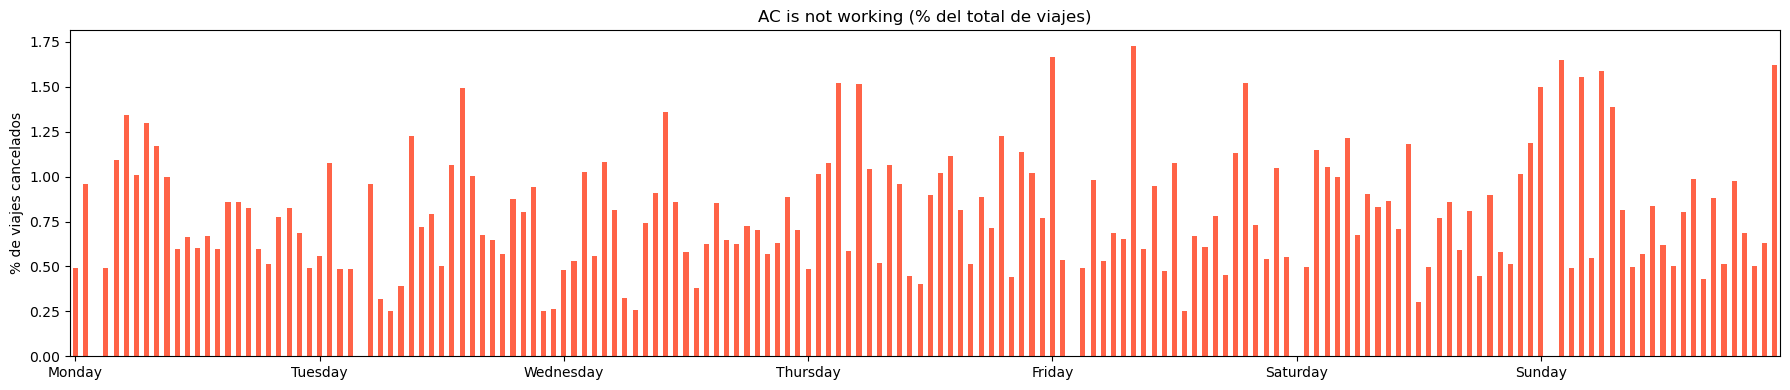

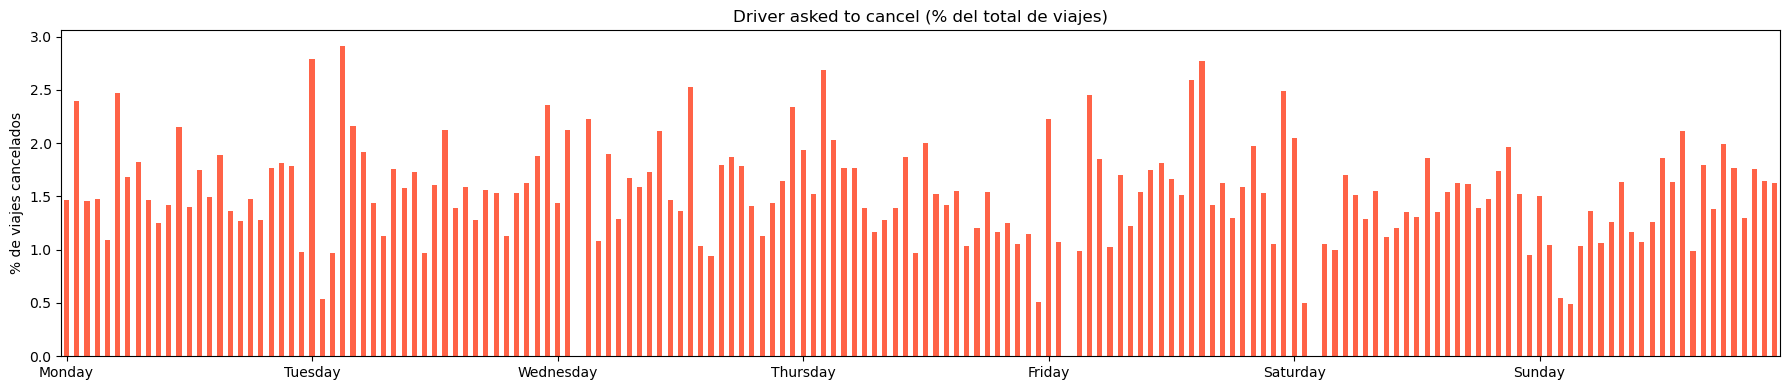

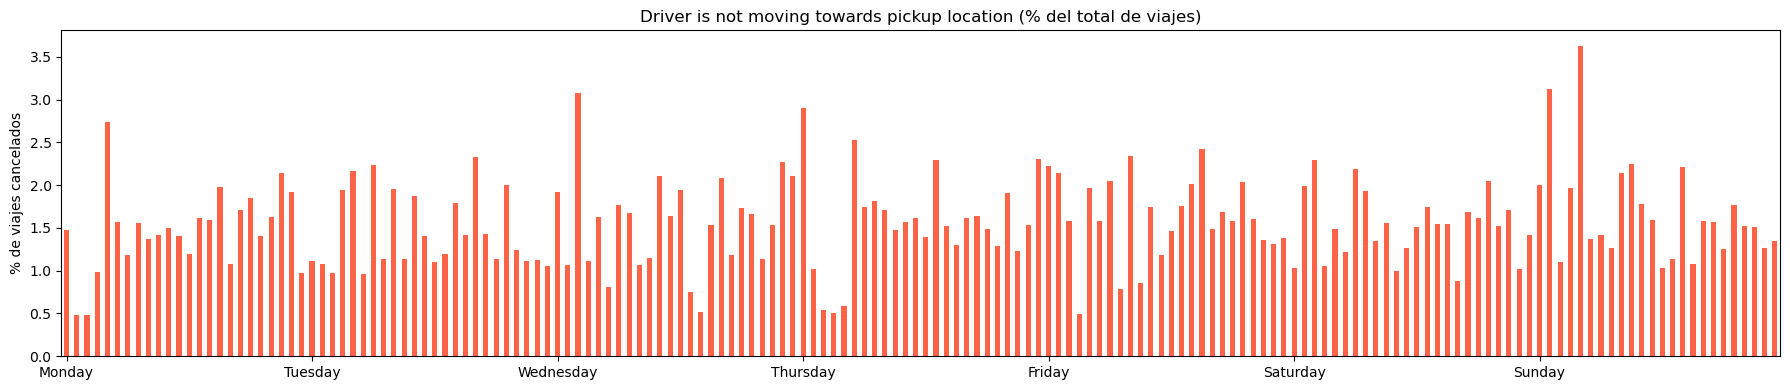

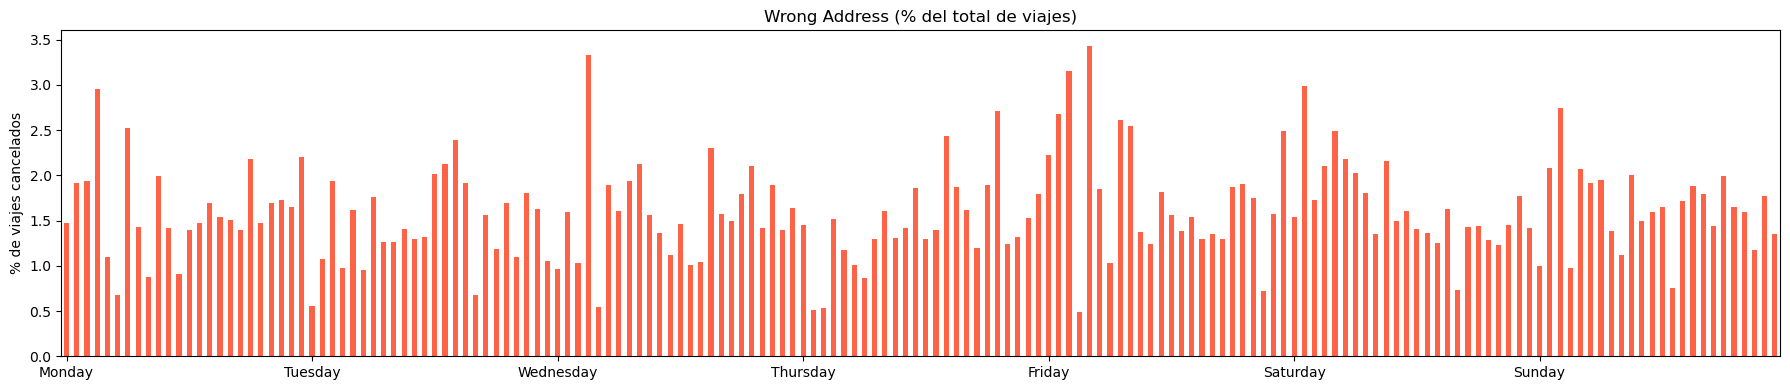

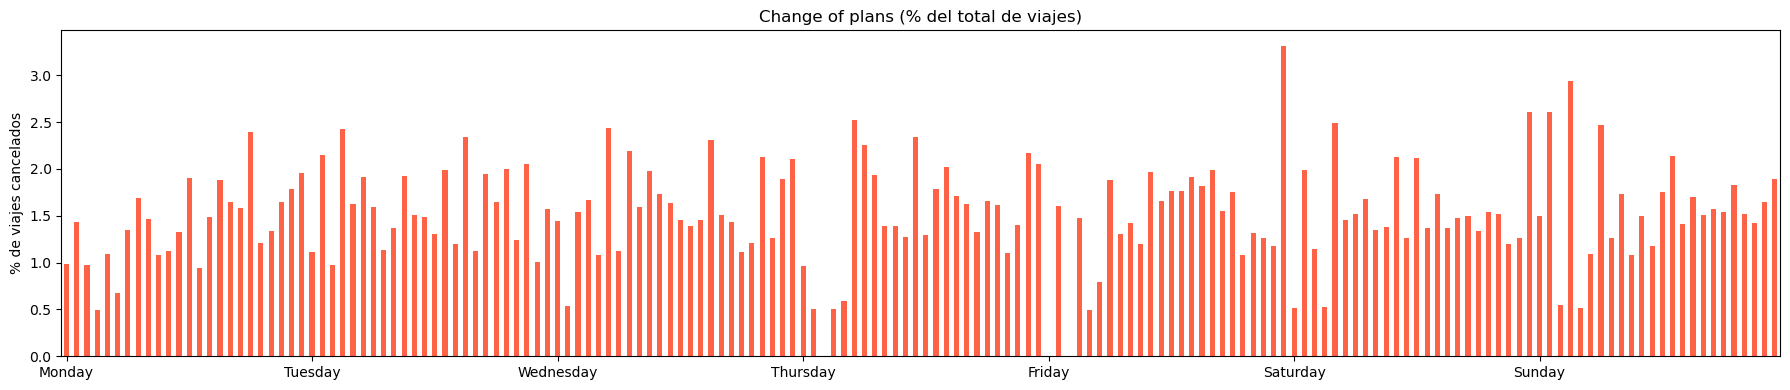

In [12]:
reasons_list = reasons_breakdown["Reason for cancelling by Customer"].unique()

for reason in reasons_list:
    subset = reasons_breakdown[reasons_breakdown["Reason for cancelling by Customer"] == reason]

    pivot_reason = subset.pivot_table(
        index=["DayOfWeek","Hour"],
        values="Percent of total",
        fill_value=0
    )

    pivot_reason = pivot_reason.reindex(
        pd.MultiIndex.from_product([days_order, range(24)]),
        fill_value=0
    )

    ax = pivot_reason.plot(kind="bar", figsize=(18,4), legend=False, color="tomato")

    plt.title(f"{reason} (% del total de viajes)")
    plt.ylabel("% de viajes cancelados")
    plt.xlabel("")

    ticks = [i*24 for i in range(len(days_order))]
    ax.set_xticks(ticks)
    ax.set_xticklabels(days_order, rotation=0)

    plt.tight_layout()
    plt.show()